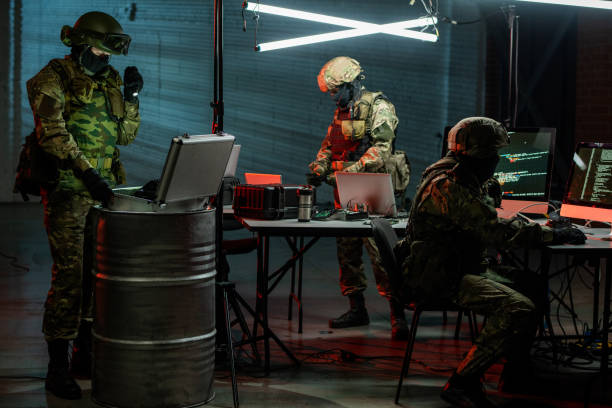
  <div style="text-align: center;">
    <h1>Crime Investigators</h1>
    <h3>Working with Crime Data</h3>
</div>

### Prerequisites:

- To run this notebook, you need to have JDK 21 or an older version installed on your system.
- Download the required CSV file from the following link:
    - Data Source: [Crimes-2001-to-Present CSV File](https://data.cityofchicago.org/Public-Safety/Crimes-2001-to-Present/ijzp-q8t2/data)


In [1]:
#Import pyspark
!pip install pyspark

## Step 1: Create a Spark session

In [2]:
#import required libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import to_date
from pyspark.sql.types import StructType, StructField, IntegerType, StringType, FloatType, TimestampType

spark = SparkSession.builder.appName("ChicagoCrimeAnalysis").config("spark.sql.legacy.timeParserPolicy", "LEGACY").getOrCreate()


In [3]:
spark

## Step 2: Define the schema for loading the Chicago crime dataset 


In [4]:
# Define the schema as a list of tuples
schema = [
    ("ID", IntegerType(), True),
    ("CaseNumber", StringType(), True),
    ("Date", StringType(), True),
    ("Block", StringType(), True),
    ("IUCR", StringType(), True),
    ("PrimaryType", StringType(), True),
    ("Description", StringType(), True),
    ("LocationDescription", StringType(), True),
    ("Arrest", StringType(), True),
    ("Domestic", StringType(), True),
    ("Beat", IntegerType(), True),
    ("District", IntegerType(), True),
    ("Ward", IntegerType(), True),
    ("CommunityArea", IntegerType(), True),
    ("FBICode", StringType(), True),
    ("XCoordinate", FloatType(), True),
    ("YCoordinate", FloatType(), True),
    ("Year", IntegerType(), True),
    ("UpdatedOn", StringType(), True),
    ("Latitude", FloatType(), True),
    ("Longitude", FloatType(), True),
    ("Location", StringType(), True)
]

# Create the StructType from the list of tuples
crime_data_schema = StructType([StructField(name, dtype, nullable) for name, dtype, nullable in schema])



## Step 3: Load the Chicago crime data

In [5]:
file_path = "Crimes_-_2001_to_Present.csv"
# Reading the CSV file with the updated variable name
crime_data_df = spark.read \
    .format("csv") \
    .option("header", "true") \
    .schema(crime_data_schema) \
    .load(file_path)


In [6]:
crime_data_df.count()

7918014

In [7]:
crime_data_df.columns

['ID',
 'CaseNumber',
 'Date',
 'Block',
 'IUCR',
 'PrimaryType',
 'Description',
 'LocationDescription',
 'Arrest',
 'Domestic',
 'Beat',
 'District',
 'Ward',
 'CommunityArea',
 'FBICode',
 'XCoordinate',
 'YCoordinate',
 'Year',
 'UpdatedOn',
 'Latitude',
 'Longitude',
 'Location']

In [8]:
crime_data_df.show(5)  # Display the first 10 rows


+--------+----------+--------------------+--------------------+----+--------------------+--------------------+--------------------+------+--------+----+--------+----+-------------+-------+-----------+-----------+----+--------------------+---------+---------+--------------------+
|      ID|CaseNumber|                Date|               Block|IUCR|         PrimaryType|         Description| LocationDescription|Arrest|Domestic|Beat|District|Ward|CommunityArea|FBICode|XCoordinate|YCoordinate|Year|           UpdatedOn| Latitude|Longitude|            Location|
+--------+----------+--------------------+--------------------+----+--------------------+--------------------+--------------------+------+--------+----+--------+----+-------------+-------+-----------+-----------+----+--------------------+---------+---------+--------------------+
| 5741943|  HN549294|08/25/2007 09:22:...|  074XX N ROGERS AVE|0560|             ASSAULT|              SIMPLE|               OTHER| false|   false|2422|      24

## Step 4: Clean the data
- <h3>Remove all null values</h3>

In [9]:
# Iterate through columns and display null values
for column in crime_data_df.columns:
    null_count = crime_data_df.filter(crime_data_df[column].isNull()).count()
    if null_count > 0:
        print(f"Column '{column}' has {null_count} null values")

Column 'LocationDescription' has 11934 null values
Column 'District' has 47 null values
Column 'Ward' has 614849 null values
Column 'CommunityArea' has 613476 null values
Column 'XCoordinate' has 90147 null values
Column 'YCoordinate' has 90147 null values
Column 'Latitude' has 90147 null values
Column 'Longitude' has 90147 null values
Column 'Location' has 90147 null values


### Observations:
- From this, we can observe that we should not remove all the rows with null values because doing so may result in the loss of data. Instead, we should carefully consider whether to remove or replace these values based on the specific circumstances. 

In [10]:
# Replace missing values in 'LocationDescription' with 'Unknown'
crime_data_df = crime_data_df.fillna("Unknown", subset=["LocationDescription"])

# Remove rows with missing values in 'District', 'XCoordinate', 'YCoordinate', 'Latitude', 'Longitude', 'Location'
crime_data_df = crime_data_df.dropna(subset=["District", "XCoordinate", "YCoordinate", "Latitude", "Longitude", "Location"])

# Replace missing values in 'Ward' and 'CommunityArea' with a default value, e.g., -1
crime_data_df = crime_data_df.fillna(-1, subset=["Ward", "CommunityArea"])

# Show the resulting DataFrame
crime_data_df.show(5)

+--------+----------+--------------------+--------------------+----+--------------------+--------------------+--------------------+------+--------+----+--------+----+-------------+-------+-----------+-----------+----+--------------------+---------+---------+--------------------+
|      ID|CaseNumber|                Date|               Block|IUCR|         PrimaryType|         Description| LocationDescription|Arrest|Domestic|Beat|District|Ward|CommunityArea|FBICode|XCoordinate|YCoordinate|Year|           UpdatedOn| Latitude|Longitude|            Location|
+--------+----------+--------------------+--------------------+----+--------------------+--------------------+--------------------+------+--------+----+--------+----+-------------+-------+-----------+-----------+----+--------------------+---------+---------+--------------------+
|13210088|  JG423627|08/31/2023 12:00:...|023XX W JACKSON BLVD|1153|  DECEPTIVE PRACTICE|FINANCIAL IDENTIT...|              STREET| false|   false|1225|      12

## observations:

- <b>LocationDescription:</b>Only some descriptions were missing, so we replaced them with 'Unknown' for clarity.
- <b>District, XCoordinate, YCoordinate, Latitude, Longitude, Location:</b>These columns had a significant number of missing values, and they are vital for spatial analysis. Removing rows with missing values in these columns was preferable as filling missing coordinates might introduce inaccuracies.
- <b>Ward and CommunityArea:</b>These columns had missing values, but they were retained for analysis, with missing values replaced with a default value (-1) to indicate the absence of specific information.

- ### Change 'Date' column data type

In [11]:
from pyspark.sql.functions import to_timestamp

print("Data type of 'Date' column before conversion:")
print(crime_data_df.dtypes)

# Change 'Date' column data type
crime_data_df = crime_data_df.withColumn("Date", to_timestamp("Date", "MM/dd/yyyy hh:mm:ss a"))

# Display the data type of 'Date' column after conversion
print("Data type of 'Date' column after conversion:")
print(crime_data_df.dtypes)

Data type of 'Date' column before conversion:
[('ID', 'int'), ('CaseNumber', 'string'), ('Date', 'string'), ('Block', 'string'), ('IUCR', 'string'), ('PrimaryType', 'string'), ('Description', 'string'), ('LocationDescription', 'string'), ('Arrest', 'string'), ('Domestic', 'string'), ('Beat', 'int'), ('District', 'int'), ('Ward', 'int'), ('CommunityArea', 'int'), ('FBICode', 'string'), ('XCoordinate', 'float'), ('YCoordinate', 'float'), ('Year', 'int'), ('UpdatedOn', 'string'), ('Latitude', 'float'), ('Longitude', 'float'), ('Location', 'string')]
Data type of 'Date' column after conversion:
[('ID', 'int'), ('CaseNumber', 'string'), ('Date', 'timestamp'), ('Block', 'string'), ('IUCR', 'string'), ('PrimaryType', 'string'), ('Description', 'string'), ('LocationDescription', 'string'), ('Arrest', 'string'), ('Domestic', 'string'), ('Beat', 'int'), ('District', 'int'), ('Ward', 'int'), ('CommunityArea', 'int'), ('FBICode', 'string'), ('XCoordinate', 'float'), ('YCoordinate', 'float'), ('Yea

## Step 5: Filter the data for last ten years.

In [12]:
crime_data_df = crime_data_df.filter(crime_data_df["Year"] >= 2013)

# Show the filtered DataFrame
crime_data_df.show(5)

+--------+----------+-------------------+--------------------+----+--------------------+--------------------+--------------------+------+--------+----+--------+----+-------------+-------+-----------+-----------+----+--------------------+---------+---------+--------------------+
|      ID|CaseNumber|               Date|               Block|IUCR|         PrimaryType|         Description| LocationDescription|Arrest|Domestic|Beat|District|Ward|CommunityArea|FBICode|XCoordinate|YCoordinate|Year|           UpdatedOn| Latitude|Longitude|            Location|
+--------+----------+-------------------+--------------------+----+--------------------+--------------------+--------------------+------+--------+----+--------+----+-------------+-------+-----------+-----------+----+--------------------+---------+---------+--------------------+
|13210088|  JG423627|2023-08-31 12:00:00|023XX W JACKSON BLVD|1153|  DECEPTIVE PRACTICE|FINANCIAL IDENTIT...|              STREET| false|   false|1225|      12|  2

## Step 6: Remove all the records with the following crime types:

- 'NON-CRIMINAL (SUBJECT SPECIFIED)'
- 'OTHER OFFENSE'
- 'STALKING'
- 'NON - CRIMINAL'
- 'ARSON'


In [13]:
# Define the list of crime types to remove
crime_types_to_remove = ['NON-CRIMINAL (SUBJECT SPECIFIED)', 'OTHER OFFENSE', 'STALKING', 'NON - CRIMINAL', 'ARSON']

# Count the occurrences of each crime type before removal
count_before = crime_data_df.filter(crime_data_df["PrimaryType"].isin(crime_types_to_remove)).count()

# Remove records with the specified crime types
crime_data_df = crime_data_df.filter(~crime_data_df["PrimaryType"].isin(crime_types_to_remove))

# Count the occurrences of each crime type after removal
count_after = crime_data_df.filter(crime_data_df["PrimaryType"].isin(crime_types_to_remove)).count()

# Check if the specified crime types have been removed
if count_before != count_after:
    print("The specified crime types have been successfully removed.")
else:
    print("Some specified crime types may still be present in the DataFrame.")


The specified crime types have been successfully removed.


## Step 7: Merge the similar crime types.
- For example, change 'Primary Type' of cases that have 'Primary Type' as ‘SEX OFFENSE’ or ‘PROSTITUTION’ such that they should have the same 'Primary Type'.

In [14]:
from pyspark.sql.functions import expr
# Use the expr function to merge similar crime types
crime_data_df = crime_data_df.withColumn("PrimaryType", expr(
    "CASE WHEN PrimaryType IN ('SEX OFFENSE', 'PROSTITUTION') THEN 'SEX OFFENSE/PROSTITUTION' ELSE PrimaryType END"
))

In [15]:
# Get distinct values from the 'PrimaryType' column
distinct_primary_types = crime_data_df.select("PrimaryType").distinct()

# Show the distinct primary types
distinct_primary_types.show()

+--------------------+
|         PrimaryType|
+--------------------+
|OFFENSE INVOLVING...|
|CRIMINAL SEXUAL A...|
|PUBLIC PEACE VIOL...|
|           OBSCENITY|
|            GAMBLING|
|   CRIMINAL TRESPASS|
|             ASSAULT|
|LIQUOR LAW VIOLATION|
| MOTOR VEHICLE THEFT|
|               THEFT|
|             BATTERY|
|SEX OFFENSE/PROST...|
|             ROBBERY|
|            HOMICIDE|
|   HUMAN TRAFFICKING|
|        INTIMIDATION|
|  DECEPTIVE PRACTICE|
|CONCEALED CARRY L...|
|     CRIMINAL DAMAGE|
|           NARCOTICS|
+--------------------+
only showing top 20 rows



## Step 8: Analyze the data and present results:
- Show year-wise trend of the crime for last ten years.

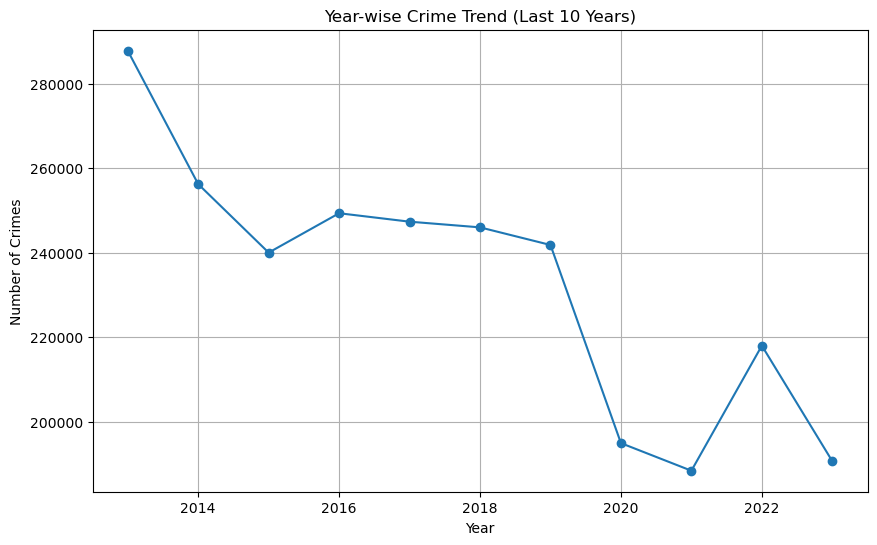

In [16]:
import matplotlib.pyplot as plt
# Group the data by year and count the number of crimes
yearly_crime_count = crime_data_df.groupBy("Year").count().orderBy("Year")

# Convert to Pandas DataFrame for plotting
yearly_crime_count_pd = yearly_crime_count.toPandas()

# Plot year-wise trend as a line plot
plt.figure(figsize=(10, 6))
plt.plot(yearly_crime_count_pd["Year"], yearly_crime_count_pd["count"], marker='o', linestyle='-')
plt.title("Year-wise Crime Trend (Last 10 Years)")
plt.xlabel("Year")
plt.ylabel("Number of Crimes")
plt.grid(True)

# Show the line plot
plt.show()

### 2.Find out at which hour of the day crime is highest

+----+------+
|Hour| count|
+----+------+
|  12|148153|
+----+------+
only showing top 1 row



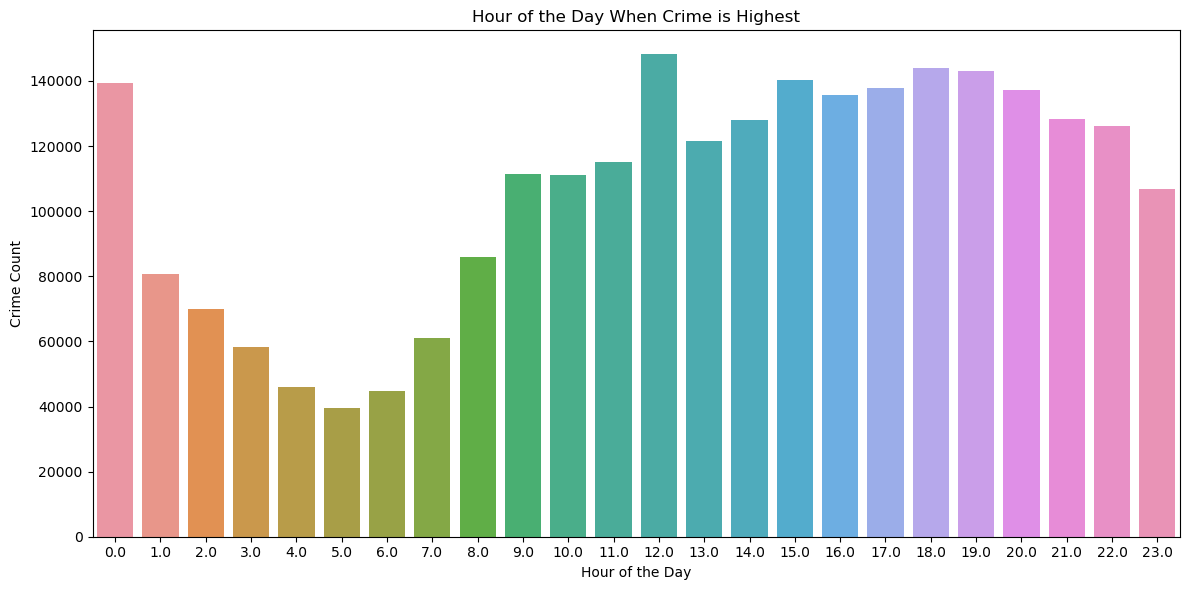

In [17]:
import seaborn as sns
from pyspark.sql.functions import hour


# Group crime data by the hour component of the 'Date' column, count occurrences for each hour, and order the results by count in descending order, creating 'hourly_crime' DataFrame.
hourly_crime = crime_data_df.groupBy(hour("Date").alias("Hour")).count().orderBy("count", ascending=False)
hourly_crime.show(1)  # Show the hour with the highest crime count

# Set a color palette for Seaborn
sns.set_palette("pastel")

# Convert the PySpark DataFrame 'hourly_crime' to a Pandas DataFrame
hourly_crime_pandas = hourly_crime.toPandas()
plt.figure(figsize=(12, 6))
sns.barplot(x=hourly_crime_pandas["Hour"], y=hourly_crime_pandas["count"])
plt.xlabel("Hour of the Day")
plt.ylabel("Crime Count")
plt.title("Hour of the Day When Crime is Highest")
plt.xticks(range(0, 24))
plt.tight_layout()
plt.show()

### 3.Find top ten crimes and present them as a bar chart.

In [18]:
# Assuming df is your DataFrame
crime_data_df.createOrReplaceTempView("crime_data")

# Use SQL to find the top 10 crimes
query = """
SELECT PrimaryType, COUNT(*) AS crime_count
FROM crime_data
GROUP BY PrimaryType
ORDER BY crime_count DESC
LIMIT 10
"""

top10_crimes_df = spark.sql(query).toPandas()

In [19]:
top10_crimes_df

,PrimaryType,crime_count
0,THEFT,616131
1,BATTERY,508054
2,CRIMINAL DAMAGE,301359
3,ASSAULT,207674
4,DECEPTIVE PRACTICE,174029
5,NARCOTICS,156395
6,MOTOR VEHICLE THEFT,138866
7,BURGLARY,122586
8,ROBBERY,105767
9,CRIMINAL TRESPASS,64235


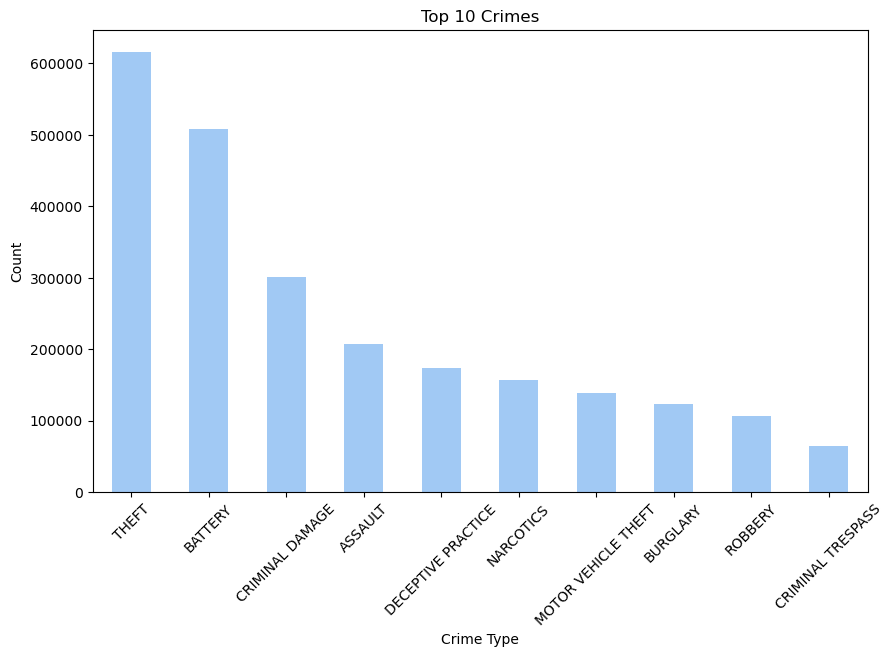

In [20]:
# Set the size of the figure
fig, ax = plt.subplots(figsize=(10, 6))
top10_crimes_df.plot(kind='bar', x='PrimaryType', y='crime_count', legend=False,ax=ax)
plt.title('Top 10 Crimes')
plt.xlabel('Crime Type')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()